## Data Workflow 

This notebooks contains the basic workflow for processing the WoFS data for identifying confident supercell forecasts and centering patches to extract environmental data. 


In [1]:
# Conda requirement: python 3.8, xarray, numpy, scipy, numba, monte_python, scikit-explain

# Import required libraries 
from glob import glob 
from os.path import join
from datetime import timedelta

# Xarray is a great library for processing n-dimensional arrays! 
import xarray as xr 
import numpy as np 
import pandas as pd
import numba as nb 
from scipy.ndimage import maximum_filter
from skexplain.common.multiprocessing_utils import run_parallel, to_iterator 

# Download https://github.com/WarnOnForecast/wofs_ml_severe
# change your system path. This script handles loading the 
# the storm events CSV file and getting the correct reports 
# for a given time range. 
import sys
sys.path.append('/home/monte.flora/python_packages/wofs_ml_severe')
from wofs_ml_severe.data_pipeline.storm_report_loader import StormReportLoader

# To use MontePython, clone it to your local directory
# and then run `python setup.py install` 
import monte_python 
from monte_python.object_identification import quantize_probabilities

In [2]:
# Set the constant variables (like base paths).
# Some of these parameters are tunable, so I encourage you to play around with them!

BASE_DATA_PATH = '/work/mflora/SummaryFiles/'
OUTDIR = '/work/mflora/tmp'
ENSEMBLE_SIZE = 18 
PATCH_SIZE_RADIUS = 40 # on a 3-km grid, this would be 40 x 40 patch or 120 x 120 km grid. 
PROB_THRESH = 4/18 
N_JOBS = 1
SVR_VARIABLES = ['srh_0to1', 'cape_ml', 'cin_ml']

STORM_EVENTS_PATH = join(OUTDIR, 'StormEvents_2017-2021.csv')

PARAMS = {'min_thresh': 5,
         'max_thresh': 18,
         'data_increment':1,
         'area_threshold': 500,
         'dist_btw_objects': 25} 

### Functions for loading the WoFS summary files and the observed storm reports

In [3]:
def load_wofs_data(date, init_time, time_index):
    """Load the appropriate WoFS summary files"""
    assert time_index>=12 
    # The lead time for the supercell has to be a minimum of 1 hr
    # This prevents sampling too close to initialization 
    # and allow us to consistently sample the enviroment 
    # at a series of preceding times (e.g., t-45, t-30, t-15, t-60)
    file_path_ens = glob(join(BASE_DATA_PATH, date, init_time, f'wofs_ENS_{time_index:02d}*'))[0]
    
    # Samples the WoFS SVR file every 15 going back an hour. 
    preceding_time_idxs = np.arange(time_index-12, time_index, 3)
    
    file_paths_svr = [glob(join(BASE_DATA_PATH, date, init_time, f'wofs_SVR_{t:02d}*'))[0] 
                     for t in preceding_time_idxs]

    ds_ens = xr.load_dataset(file_path_ens, decode_times=False)
    
    ds_svr = xr.concat([xr.load_dataset(f, decode_times=False) 
                        for f in file_paths_svr], dim='time')
    
    return ds_ens, ds_svr, file_path_ens


def load_reports(ncfile, date, init_time, time_index):
    """Load observed storm reports. This will load any severe or significant severe reports 
    for tornadoes, severe wind, and severe hail."""
    DT = 5 
    init_dt = date+init_time
    initial_time = (pd.to_datetime(init_dt)+timedelta(minutes=time_index*DT)).strftime('%Y%m%d%H%M')
    loader = StormReportLoader(reports_path = STORM_EVENTS_PATH,
                               report_type = 'NOAA',
                               initial_time = initial_time,
                               forecast_length = 0,
                               err_window = 15,
    )
    
    ds = xr.open_dataset(ncfile, decode_times=False)
    ds_reports = loader.to_grid(dataset=ds)

    ds.close()
    del ds
    
    return ds_reports


def save_dataset(fname, dataset):
    """ saves xarray dataset to netcdf using compression """
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in dataset.data_vars}
    #os.makedirs(os.path.dirname(fname), exist_ok=True)
    dataset.to_netcdf( path = fname, encoding=encoding )
    dataset.close( )
    del dataset

### Utility functions for computing ensemble statistics and extracting patches from the WoFS data 

In [4]:
def compute_ensemble_mean(dataset, data_vars):
    dataset = dataset[data_vars]
    dataset = dataset.mean(dim='ne') 
    dataset = dataset.rename({n : f'{n}_ens_mean' for n in dataset.data_vars})
    
    return dataset
    

@nb.jit(nopython=True)
def extract_patch_3d(data, centers, delta=10):
    """Extract patches 
    
    data : shape of (v,y,x)
    centers  
    """
    # Ensure the centers do not conflict the boundaries. 
    centers = nb.typed.List(centers)
    
    patches = [ ]
    for obj_y, obj_x in centers:
        patches.append( data[:,:, obj_y-delta:obj_y+delta, obj_x-delta:obj_x+delta] )

    return patches


@nb.jit(nopython=True)
def extract_patch_2d(data, centers, delta=10):
    """Extract patches 
    
    data : shape of (v,y,x)
    centers  
    """
    # Ensure the centers do not conflict the boundaries. 
    centers = nb.typed.List(centers)
    
    patches = [ ]
    for obj_y, obj_x in centers:
        patches.append( data[:, obj_y-delta:obj_y+delta, obj_x-delta:obj_x+delta] )

    return patches


### Computing the ensemble probability of a supercell 

In [5]:
def compute_supercell_probability(dataset, max_size=5, classify_embedded=True):
    """Compute the neighborhood maximum ensemble probability (NMEP; Schwartz and Sobash 2017) 
    of a supercell. Supercells are identified using the storm mode classification 
    scheme from Potvin et al. (2022). 
    
    Parameters
    --------------------
    dataset : xarray.dataset 
        A WoFS ENS summary file containing `comp_dz` and `uh_2to5_instant`.
    
    max_size : int (default=5)
        The maximum filter diameter (in grid points)
    
    classify_embedded : True/False (default=True)
        Setting classify_embedded=False restricts the storm mode classification 
        to a 3-mode scheme, which runs much faster than the 7-mode scheme. 
    
    References: 
        Schwartz, C. S. & Sobash, R. A. (2017). Generating probabilistic forecasts from 
        convection-allowing ensembles using neighborhood approaches: 
        A review and recommendations. Monthly Weather Review. 
        https://doi.org/10.1175/mwr-d-16-0400.1
        
        Potvin, C. K., and co-authors (2022). An Iterative Storm Segmentation 
        and Classification Algorithm for Convection-Allowing Models and Gridded Radar Analyses,
        Journal of Atmospheric and Oceanic Technology, 39(7), 999-1013.
    """
    # Identify supercell regions per ensemble member. 
    supercell_per_mem = []

    for i in range(ENSEMBLE_SIZE):  
        dbz_vals = dataset['comp_dz'].values[i,:,:]
        rot_vals = dataset['uh_2to5_instant'].values[i,:,:]
        clf = monte_python.StormModeClassifier()
        # Setting classify_embedded=False, restricts the storm mode classification 
        # to a 3-mode scheme, which runs much faster than the 7-mode scheme. 
        storm_modes, labels, dbz_props = clf.classify(dbz_vals, rot_vals, 
                                                      classify_embedded=classify_embedded)

        # We want to isolate the supercells within the domain. 
        supercell_label = clf.MODES.index('SUPERCELL')+1
        supercell_binary = np.where(storm_modes==supercell_label,1,0)

        # Apply a maximum value filter to reduce phase errors between members
        supercell_binary = maximum_filter(supercell_binary, size=max_size)

        supercell_per_mem.append(supercell_binary)

    # Compute the ensemble probability of a supercell
    supercell_prob = np.mean(supercell_per_mem, axis=0)
    
    return supercell_prob 

### Locating supercell locations in the WoFS domain using the ensemble probabilities 

In [6]:
def identify_supercell_centers(supercell_prob, params, return_data=False):
    """Identify supercell centers using the enhanced watershed image segementation 
    method in MontePython."""
    input_data = quantize_probabilities(supercell_prob, ENSEMBLE_SIZE)
    
    sup_labels, sup_props = monte_python.label(input_data = input_data, 
                       method ='watershed', 
                       return_object_properties=True, 
                       params = params
                       )

    # Use those supercells to center the patches 
    centers = [region.centroid for region in sup_props] 
    
    if return_data:
        return sup_labels, sup_props, input_data
    else:
        return centers

### Extracting the supercell-centered data and creating an xarray.Dataset

In [7]:
def get_storm_patches(centers, ds_svr, ds_reports, supercell_prob):
    """Using the supercell NMEP, identify object centers and then 
    extract the patches. """
    # (Optional): This initial script just computes the ensemble mean 
    # environmental field. In the future, you may want to expand compute
    # other statistics. 
    dataset = compute_ensemble_mean(ds_svr, SVR_VARIABLES)
    new_variables = list(dataset.data_vars)
    
    # Add the supercell probabilities to the dataset. 
    dataset['supercell probs'] = (['NY', 'NX'], supercell_prob)
    
    # Append the reports
    ds_reports_vars = list(ds_reports.data_vars)
    for v in ds_reports_vars:
        dataset[v] = (['NY', 'NX'], ds_reports[v].values)
    
    variables_3d = new_variables
    variables_2d = [v for v in dataset.data_vars if v not in variables_3d]
    
    variables = list(dataset.data_vars)
    data_3d = np.array([dataset[v].values for v in variables_3d])
    data_2d = np.array([dataset[v].values for v in variables_2d])
    
    patches_2d = np.array(extract_patch_2d(data_2d, centers, delta=PATCH_SIZE_RADIUS))
    patches_3d = np.array(extract_patch_3d(data_3d, centers, delta=PATCH_SIZE_RADIUS))

    dict_2d = {v : (['n_samples', 'ny', 'nx'], patches_2d[:,i,:,:]) for i,v in enumerate(variables_2d)}
    dict_3d = {v : (['n_samples', 'nt', 'ny', 'nx'], patches_3d[:,:,i,:,:]) for i,v in enumerate(variables_3d)}
    
    data = {**dict_2d, **dict_3d}
    
    # Convert data to xarray.Dataset.
    dataset = xr.Dataset(data)
    
    return dataset 

## Example Workflow

In [8]:
# You'll create a list of cases, init times. At the moment, time indices should start at 12 (=60 min forecast).
# In the future, you can explore longer lead times!
dates = ['20210524']# '20210526']
init_times = ['2000']
time_indices = [12]

# TODO: add the storm reports!! 

def worker_fn(date, init_time, time_index):
    """A worker function for multiprocessing."""

    # Load the data. 
    #try:
    ds_ens, ds_svr, ens_file = load_wofs_data(date, init_time, time_index)
    ds_reports = load_reports(ens_file, date, init_time, time_index)
        
    #except:
    #    print(f'Unable to load data for {date}, {init_time}, {time_index}')
    #    return None
        
    # Compute the probability of a supercell. 
    # max_size and classify_embedded are changable parameters. I initially picked 
    # a larger max_size to increase the odds of identifying confident supercell 
    # forecasts. I classify_embedded = True to also increase the odds of identify
    # potentially embedded supercells. 
    supercell_prob = compute_supercell_probability(ds_ens, max_size=5, classify_embedded=True)

    # Check that supercell prob exceeds some threshold!
    if np.max(supercell_prob) > PROB_THRESH: 
    
        # Use those supercells to center the patches 
        centers = identify_supercell_centers(supercell_prob, PARAMS)
    
        # Get data patches. 
        dataset = get_storm_patches(centers, ds_svr, ds_reports, supercell_prob)
    
        # Save the data. 
        save_dataset(join(OUTDIR, f'wofs_data_{date}_{init_time}_{time_index}.nc'), dataset)
        
if N_JOBS == 1:
    args_iterator = to_iterator(dates, init_times, time_indices)   
    for date, init_time, time_idx in args_iterator:
        print(date, init_time, time_idx)
        worker_fn(date, init_time, time_idx)
else:
    args_iterator = to_iterator(dates, init_times, time_indices) 
    run_parallel(worker_fn, args_iterator, n_jobs=N_JOBS)

20210524 2000 12


### (Optional) Plotting the storm patches 

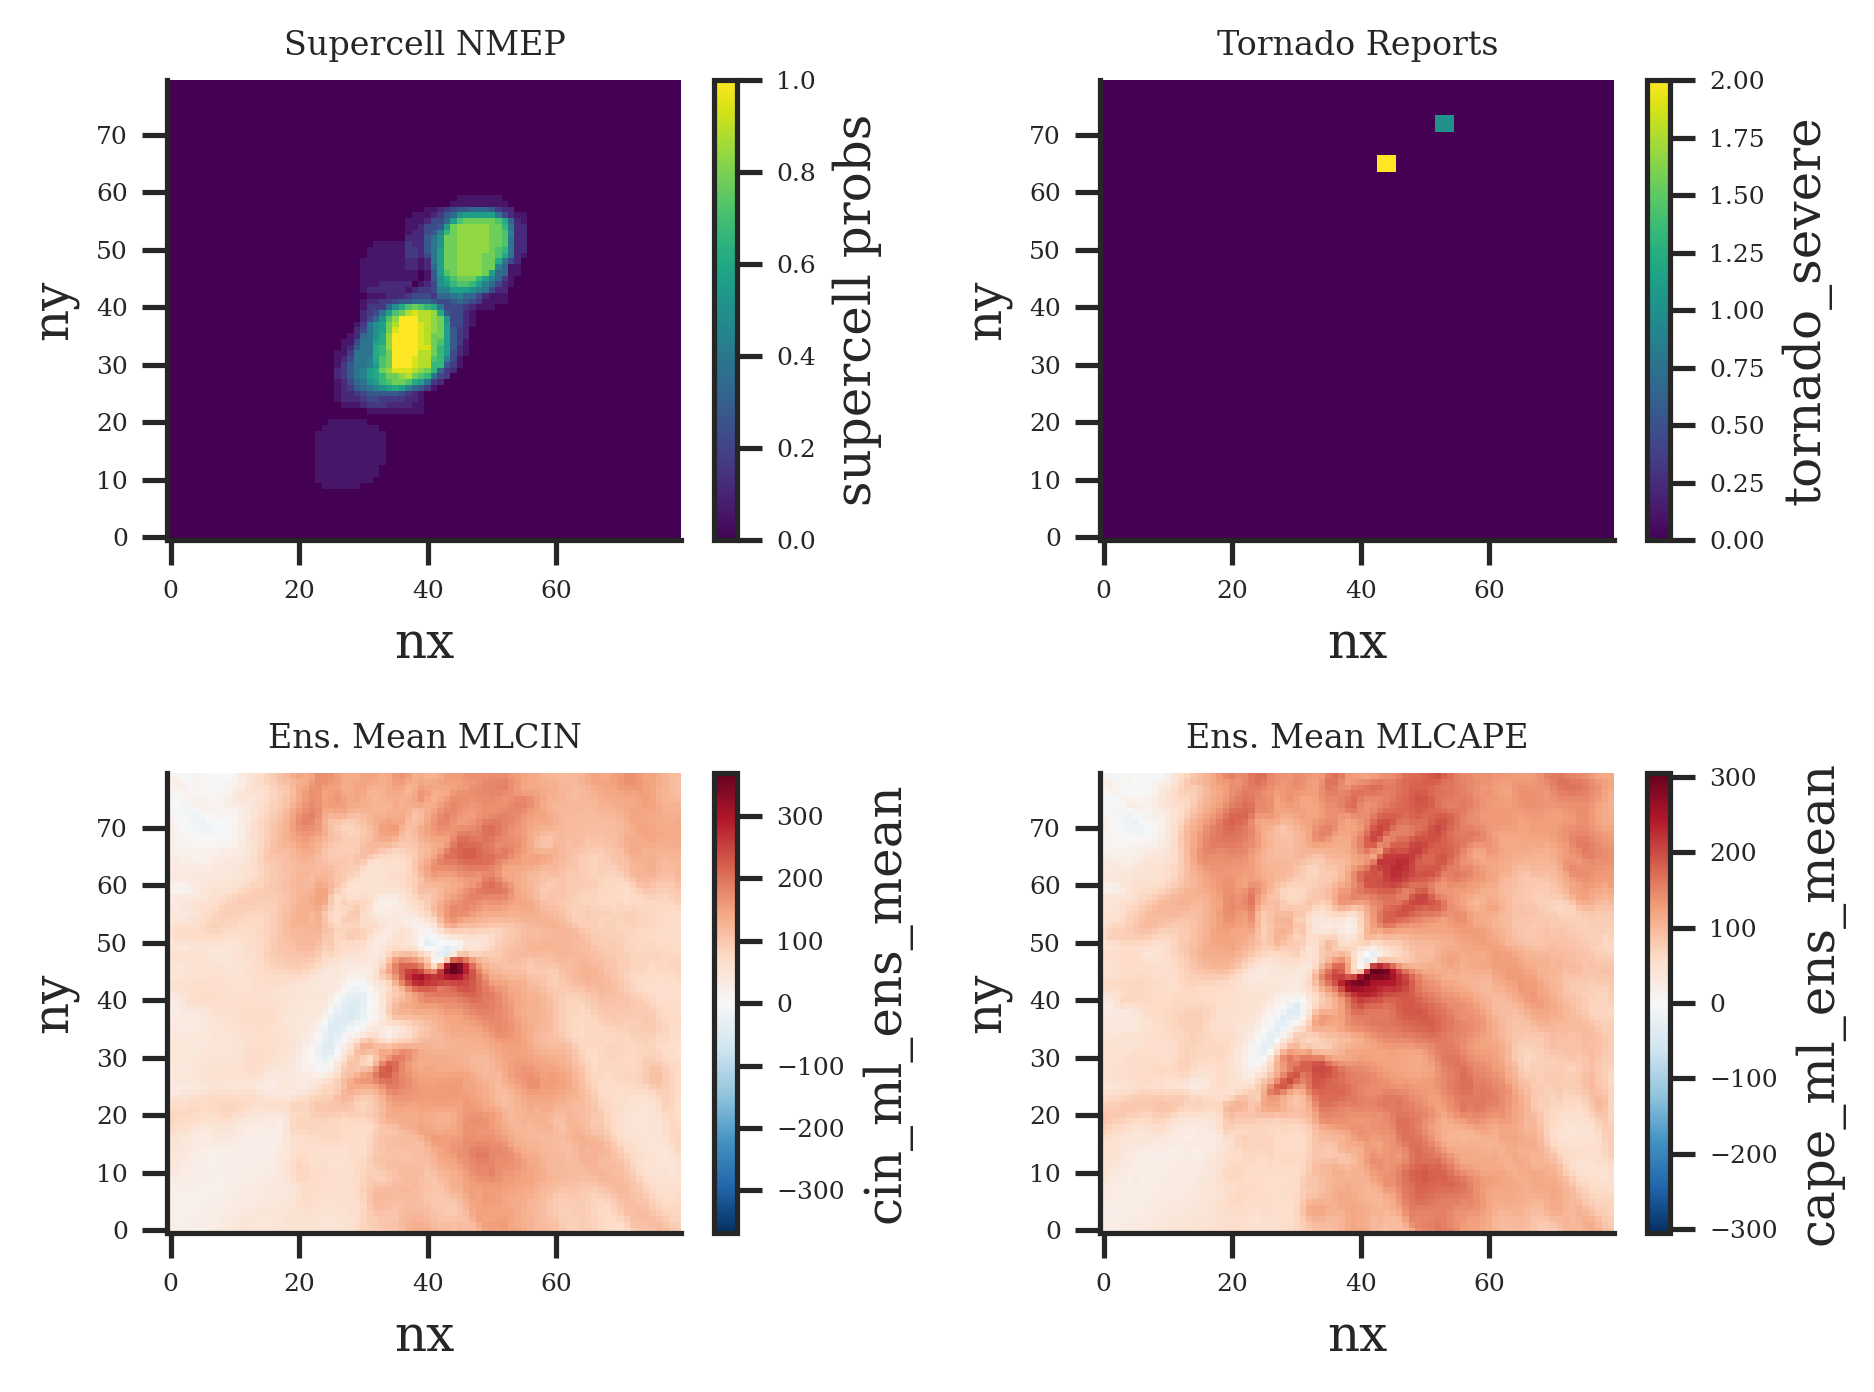

In [14]:
# You can plot data using built-in plot. In this example, I've plotted 
# the supercell ensemble probabilities (which is what the patches are centered on),
# any tornado reports, and the ensemble mean MLCIN and MLCAPE (@ t-60), respectively.

# You'll have to load the datasets to use this code! 
import matplotlib.pyplot as plt 

# You'll have to load the datasets to use this code! 
dataset = xr.load_dataset(join(OUTDIR, 'wofs_data_20210524_2000_12.nc'))

fig, axes = plt.subplots(dpi=300, nrows=2, ncols=2)

variables = ['supercell probs', 'tornado_severe', 'cin_ml_ens_mean', 'cape_ml_ens_mean']
dims = ['2d', '2d', '3d', '3d']
titles = ['Supercell NMEP', 'Tornado Reports', 'Ens. Mean MLCIN', 'Ens. Mean MLCAPE']
for i, ax in enumerate(axes.flat):
    if dims[i] == '2d':
        dataset[variables[i]][0,:,:].plot(ax=ax)
    else:
        dataset[variables[i]][0,0,:,:].plot(ax=ax)
    ax.set_title(titles[i])  
fig.tight_layout()

### (Optional) Plotting the different components of the data workflow

Remember that the storm mode label is based on the minimal integer label in a reigon!


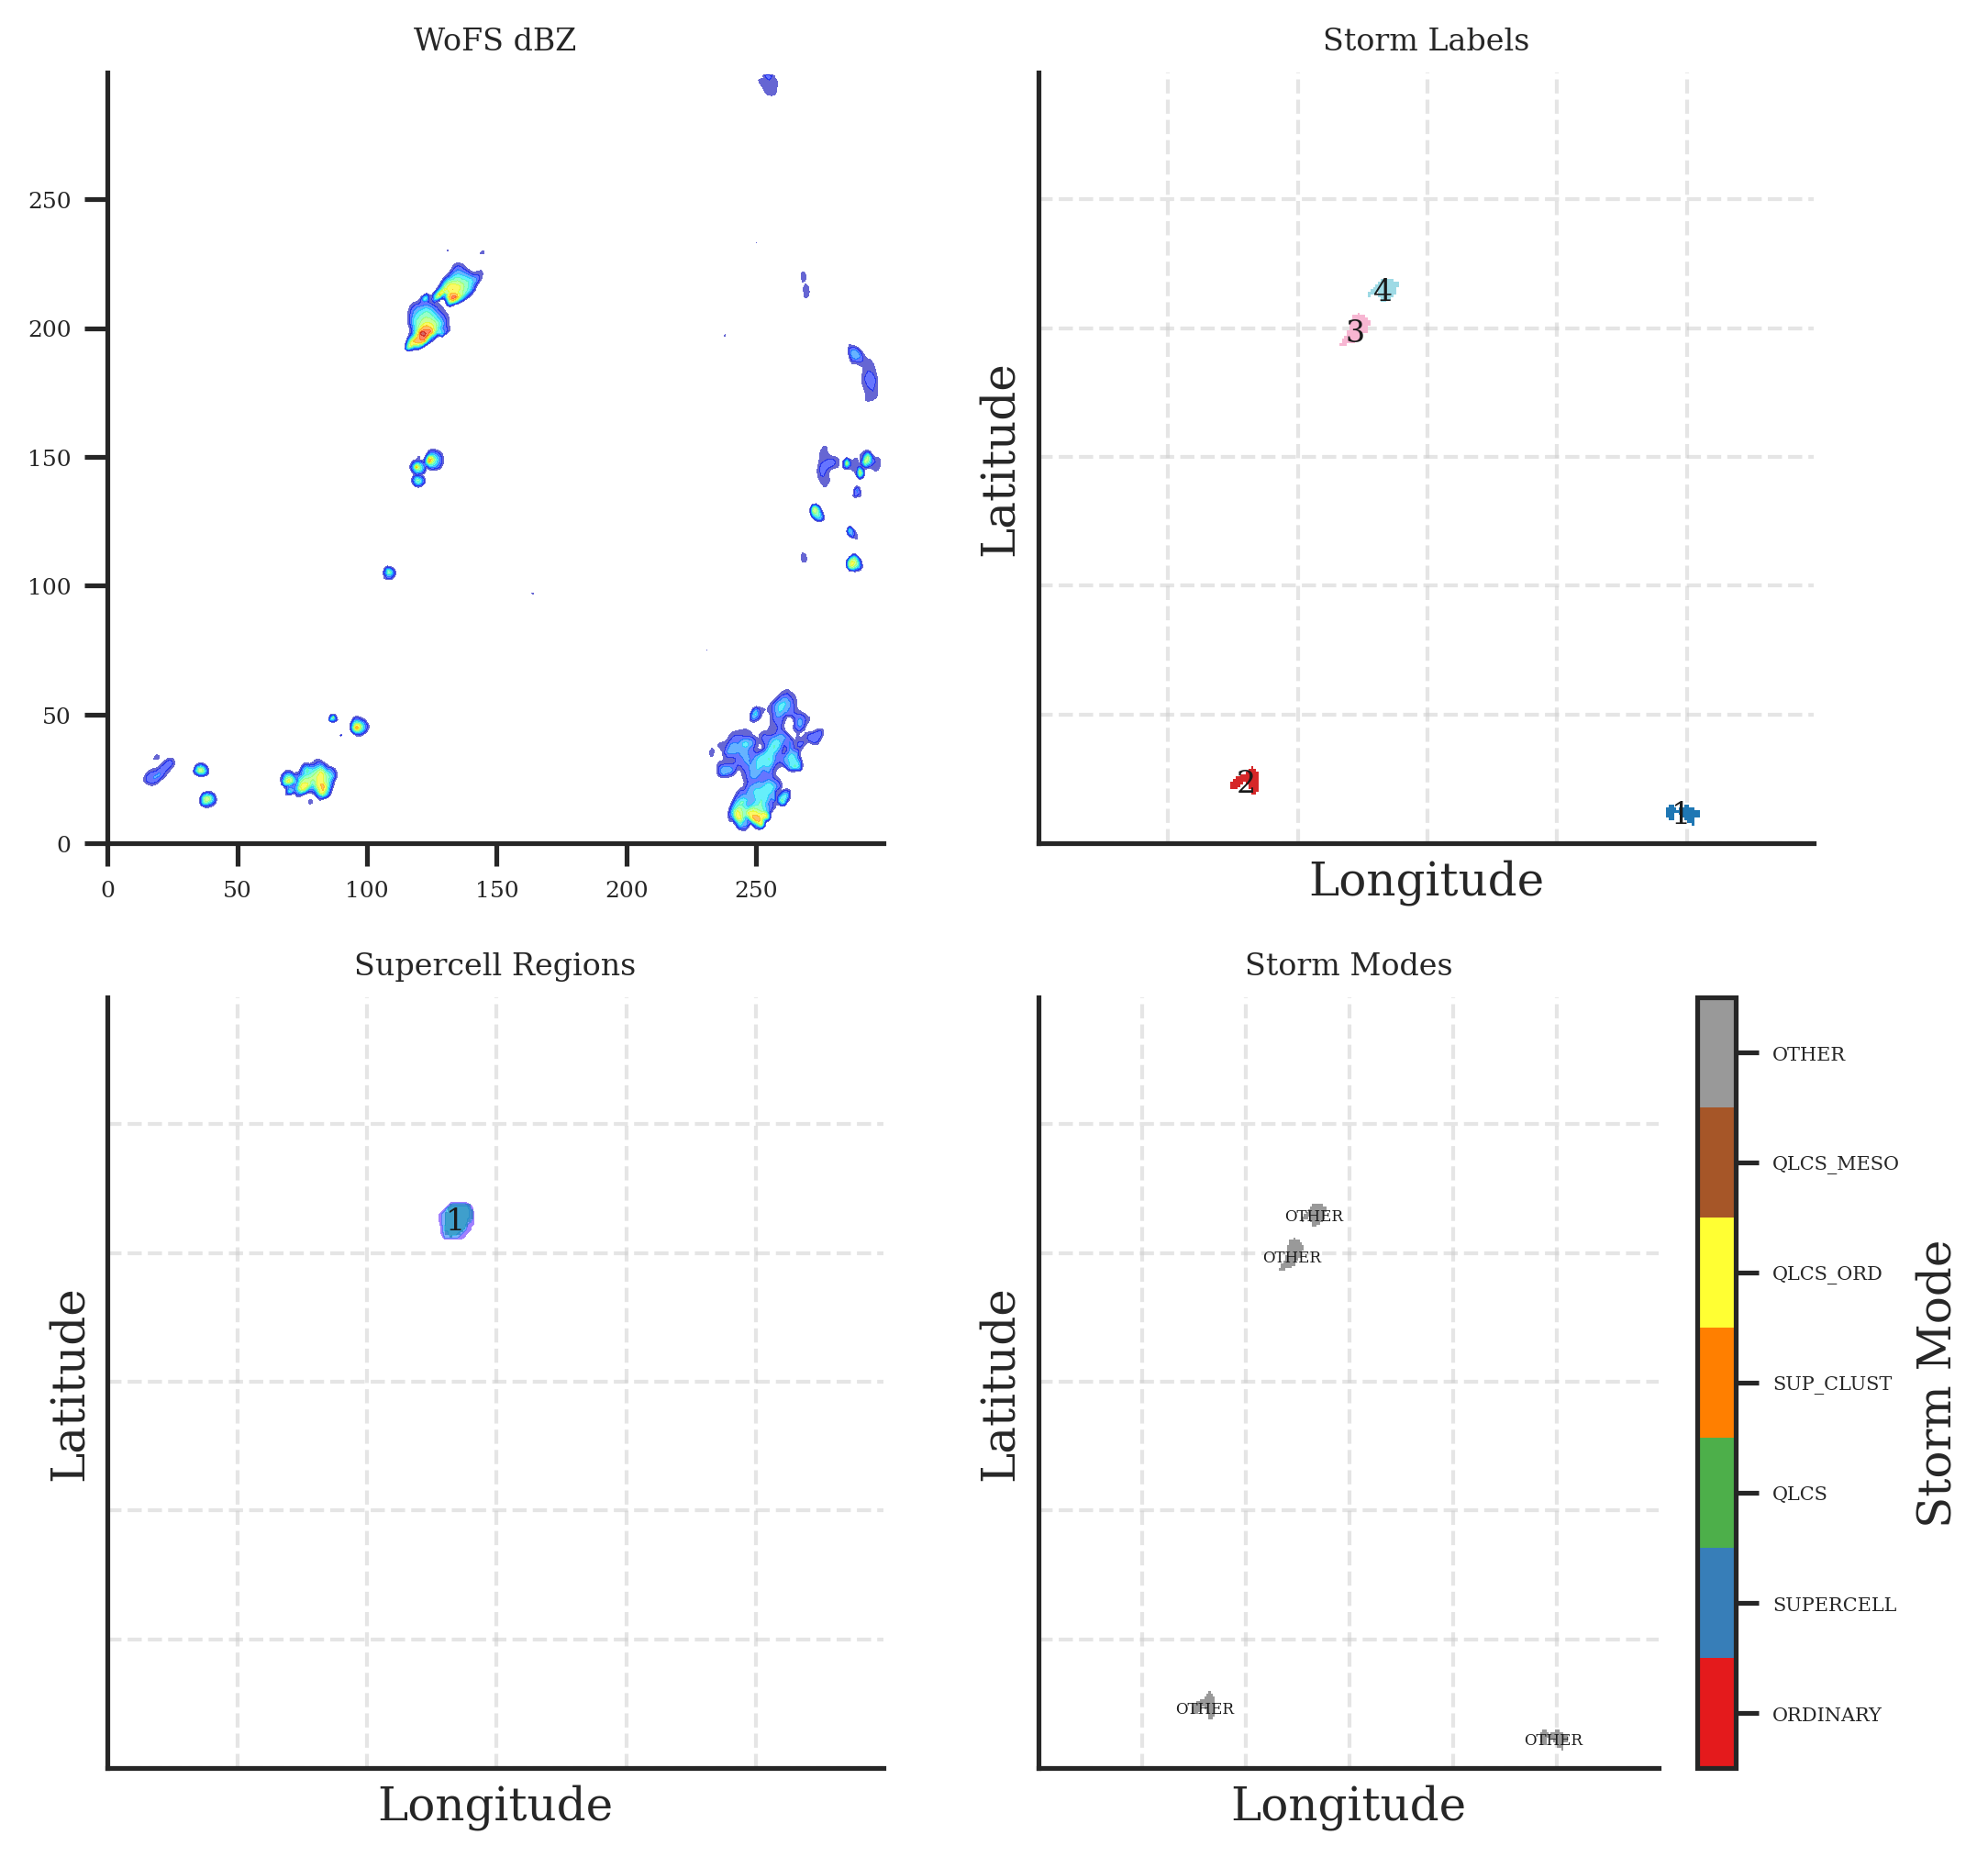

In [12]:
# (Optional) Plot the storm modes and labels to get familiar with the data! 
date = '20210524'; init_time = '2000'; time_index = 12

# This is only being shown for a single ensemble member!!!

i = 0
file_path_ens = glob(join(BASE_DATA_PATH, date, init_time, f'wofs_ENS_{time_index:02d}*'))[0]
ds_ens = xr.load_dataset(file_path_ens, decode_times=False)

dbz_vals = ds_ens['comp_dz'].values[i,:,:]
rot_vals = ds_ens['uh_2to5_instant'].values[i,:,:]
clf = monte_python.StormModeClassifier()
storm_modes, labels, dbz_props = clf.classify(dbz_vals, rot_vals, 
                                                      classify_embedded=False)

supercell_prob = compute_supercell_probability(ds_ens, max_size=5, classify_embedded=False)
sup_labels, sup_props, _ = identify_supercell_centers(supercell_prob, PARAMS, return_data=True)

x,y = np.meshgrid(range(dbz_vals.shape[0]), range(dbz_vals.shape[1]))
fig, axes = plt.subplots(dpi=300, ncols=2, nrows=2, figsize=(8,8))

axes[0,0].contourf(x,y,dbz_vals, alpha=0.6, levels=np.arange(20,75,5), cmap='jet')
monte_python.plot_storm_labels(x, y, labels, dbz_props, ax=axes[0,1]) 
monte_python.plot_storm_modes(x, y, storm_modes, dbz_props, clf.converter, ax=axes[1,1]) 

axes[1,0].contourf(x,y,supercell_prob, alpha=0.6, levels=np.arange(0.1, 1.1, 0.1), cmap='rainbow')
monte_python.plot_storm_labels(x, y, sup_labels, sup_props, ax=axes[1,0], alpha=0.6) 

titles = ['WoFS dBZ', 'Storm Labels', 'Supercell Regions', 'Storm Modes']
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i])